# StarCraft Pro Scout Modeling - Non-Parametric Models - Random Forests
Let's try ensemble methods and see how they compare.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

import scikitplot as skplt


from imblearn.over_sampling import RandomOverSampler

# Update sys.path
import sys
sys.path.append("../modules")

from scproModules import print_confusion_matrix, score_df

import pickle

In [2]:
# Pickle opening code to import cleaned data
with open('./pickles/sc_dataclean.pickle','rb') as read_file:
    scns = pickle.load(read_file)

## Non-Parametric Model Features
As a reminder, here are all of the non-parametric features  
- APM
- UniqueHotkeys
- MinimapAttacks
- MinimapRightClicks
- NumberOfPACs
- ActionsInPAC
- WorkersMade
- UniqueUnitsMade
- ComplexAbilityUsed


## Binary classifying
- Split into binary Contender and Non-Contender classes.

In [3]:
# Rename labels and resplit. The target label must be 0
scns.LeagueIndex.replace({8:1, 7:1, 6:1, 5:0, 4:0, 3:0, 2:0, 1:0}, inplace=True)
scns.LeagueIndex.value_counts().sort_index()

0    2667
1     700
Name: LeagueIndex, dtype: int64

## Train-Test-Split

- Split into main training and test sets. 
- The choice of a 25/75 split is rather arbitrary. With such a small set of pro data it's hard to know whether it's better to err on the side of a larger or smaller test set. 

In [4]:
np_features = [
 'APM',
 'UniqueHotkeys',
 'MinimapAttacks',
 'MinimapRightClicks',
 'NumberOfPACs',
 'ActionsInPAC',
 'WorkersMade',
 'UniqueUnitsMade',
 'ComplexAbilityUsed']

In [5]:
X = scns.loc[:, np_features]
y = scns['LeagueIndex']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [7]:
print(len(X_train))
print(len(X_test))

2525
842


## Oversampling Imbalanced Classes
- Before we do our training and validate splits we'll want to oversample to account for the severely imbalanced classes. 

In [8]:
ros  = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Baseline
- Again establish baseline scores using the DummyClassifier.

In [ ]:
clf = DummyClassifier(strategy='uniform')
clf.fit(X_train, y_train)
y_base_pred = clf.predict(y_test)
score_df(y_test, y_base_pred).round(4)

# Random Forest Classifier
- We'll start with a random grid search for optimal parameters.

## RandomSearchCV
- We don't know what parameters are promising so we'll do a random search to see what parameter ranges are promising. 

In [ ]:
# Random grid parameters to sample from
random_grid = {'n_estimators': [int(x) for x in np.linspace(start=100, stop=2000, num=21)],
               'max_depth': [int(x) for x in np.linspace(start=10, stop=100, num=10)] + [None],
               'min_samples_split': [2, 5, 10, 20],
               'min_samples_leaf': [1, 2, 4, 6, 8, 10],
               'bootstrap': [True, False]}

In [ ]:
# Scoring methods
scoring_methods = ['f1', 'precision', 'recall', 'accuracy', 'average_precision', 'roc_auc']

In [ ]:
# Basic Random Forest classification with 100 trees
rfc=RandomForestClassifier()
rfc_random = RandomizedSearchCV(estimator=rfc, param_distributions=random_grid, n_iter=100, 
                                scoring=scoring_methods, verbose=2, random_state=1, refit='f1', n_jobs=-1)
rfc_random.fit(X_resampled, y_resampled)

## Results Columns

In [ ]:
results_columns = [
 'param_n_estimators',
 'param_min_samples_split',
 'param_min_samples_leaf',
 'param_max_depth',
 'param_bootstrap',
 'mean_test_f1',
 'rank_test_f1',
 'mean_test_precision',
 'rank_test_precision',
 'mean_test_recall',
 'rank_test_recall',
 'mean_test_accuracy',
 'rank_test_accuracy',
 'mean_test_average_precision',
 'rank_test_average_precision',
 'mean_test_roc_auc',
 'rank_test_roc_auc',
 'mean_fit_time',
 'mean_score_time'
] 

In [ ]:
scores_columns = [ 'mean_test_f1',
 'mean_test_precision',
 'mean_test_recall',
 'mean_test_accuracy',
 'mean_test_average_precision',
 'mean_test_roc_auc',
 'mean_fit_time',
 'mean_score_time']

## RandomSearchCV Results

In [ ]:
rfc_random_df = pd.DataFrame(rfc_random.cv_results_, columns=results_columns)

In [ ]:
rfc_random_scores = pd.DataFrame(rfc_random_df.sort_values('rank_test_f1'), 
                            columns=scores_columns).round(4)

In [ ]:
rfc_random_scores.iloc[0]

In [ ]:
rfc_random_df.sort_values('rank_test_f1').iloc[0]

- These scores are superb, which makes me suspicious.
- The randomized search has given us some parameters to hone in on. 
- We'll do a GridSearch around those parameters.

## GridSearchCV

### GridSearchCV - Parameter Search

In [ ]:
# Grid search parameters
grid_params = {'n_estimators': [1665, 1715, 1765, 1810, 1865, 1915, 1975],
               'min_samples_split': [2, 3, 5, 7, 9, 11],
               'min_samples_leaf': [1, 2, 3],
               'max_depth': [50,100,150],
               'bootstrap': [True, False]}
scores = ['f1', 'precision', 'recall', 'accuracy', 'average_precision', 'roc_auc']

In [ ]:
rfc=RandomForestClassifier()
rfc_grid = GridSearchCV(estimator=rfc, param_grid=grid_params, 
                        scoring=scores, verbose=2, refit='f1', n_jobs=-1)
rfc_grid.fit(X_resampled, y_resampled)

### GridSearchCV Results

In [ ]:
rfc_grid_df = pd.DataFrame(rfc_grid.cv_results_, columns=results_columns)

In [ ]:
rfc_grid_scores = pd.DataFrame(rfc_grid_df.sort_values('rank_test_f1'), 
                            columns=scores_columns).round(4)

In [ ]:
rfc_grid_scores.iloc[0]

In [ ]:
rfc_grid_df.sort_values('rank_test_f1').iloc[0]

- Roughly the same score results, with slighly different values. The hyperparameters are just about the same too though so the randomized search pretty much did the job. 
- I could keep exploring here, but the search is extremely time-intensive. I'll end here and test with these parameters.

### TEST: Random Forest Classifier
- We'll test with the best parameters found. 

In [9]:
rfc = RandomForestClassifier(n_estimators=1715, 
                                 max_depth=150,
                                 min_samples_split=2,
                                 min_samples_leaf=1,
                                 bootstrap=False,
                                 )
rfc.fit(X_resampled, y_resampled)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=150, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1715,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [10]:
y_pred = rfc.predict(X_test)
y_probas = rfc.predict_proba(X_test)

In [11]:
score_df(y_test, y_pred, y_probas).round(4)

,Scores
f1,0.5512
precision,0.7091
recall,0.4509
accuracy,0.8492
average_precision,0.4325
roc_auc,0.8529


- Recall is just about the same as the test results for SVC. Thoroughly unimpressive. 
- All scores are actually worse than the best SVC scores. This makes some sense since SVC is best at binary classifications. 

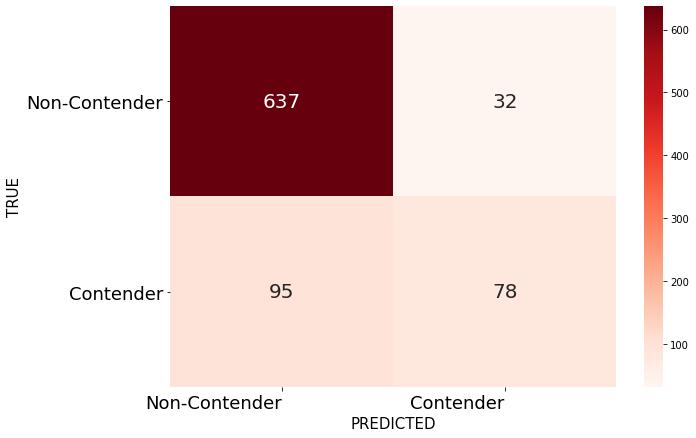

In [12]:
cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
cm = print_confusion_matrix(cnf_matrix, ['Non-Contender', 'Contender'], cmap='Reds')

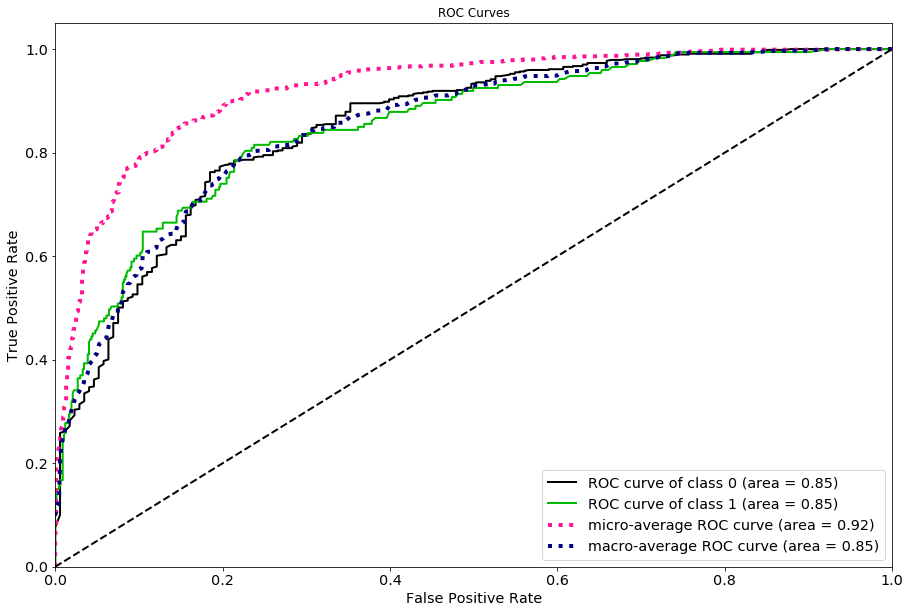

In [13]:
skplt.metrics.plot_roc(y_test, y_probas, figsize=(15,10), text_fontsize='x-large');

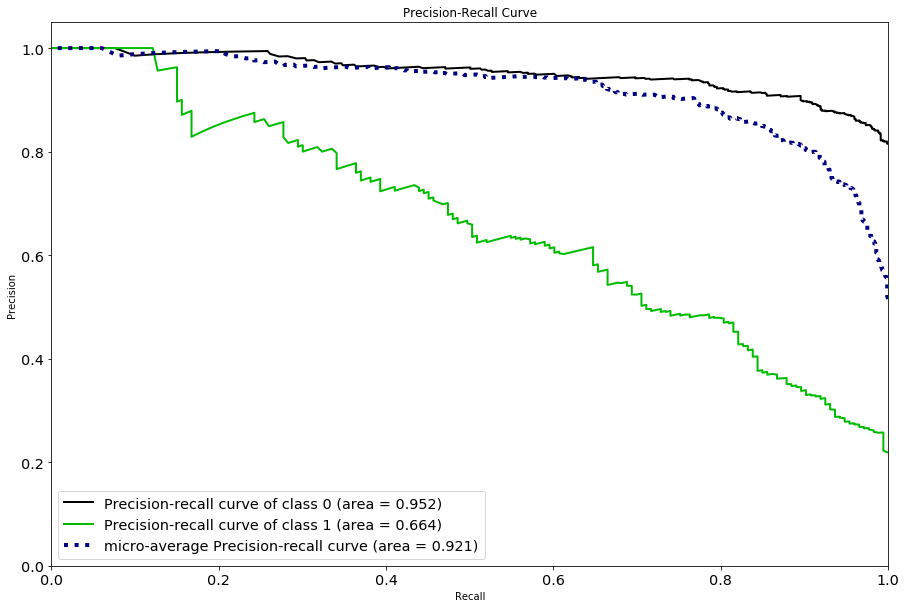

In [14]:
skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(15,10), text_fontsize='x-large');

## Random Forest Test Results Summary
- __Scores__
    - __F1: 0.5527__
    - __Precision: 0.7451__
    - __Recall: 0.4393__
    - __Accuracy: 0.8539__
    - __Average Precision: 0.4425__
- Overall the __scores of random forests__ are almost __the same as SVC__. And __like SVC, random forests__ are prioritizing __precision over recall__, but __average precision is poor regardless__. 
- However, __SVC is much less time/resource intensive than random forests__ and __KNN is the least resource intensive of the three__.
- The main thing that sticks out about __random forests is how long fitting takes__. It's __fit time is orders of magnitude longer than both KNN and SVC__, something that is of significant consideration even if it did outperform the other two. In this case __random forests did not outperform KNN and SVC__ so that along with its __very long fit time__ make it a __poor choice for this problem__. 

# Show feature importance
- A useful aspect of random forests is that they can readily __show the importance of each feature being used in modeling__. 
- Even when not using random forests as the main algorithm we can use them to identify the features that are most important for modeling, perhaps assisting in __feature selection__ and __feature engineering__.

No handles with labels found to put in legend.


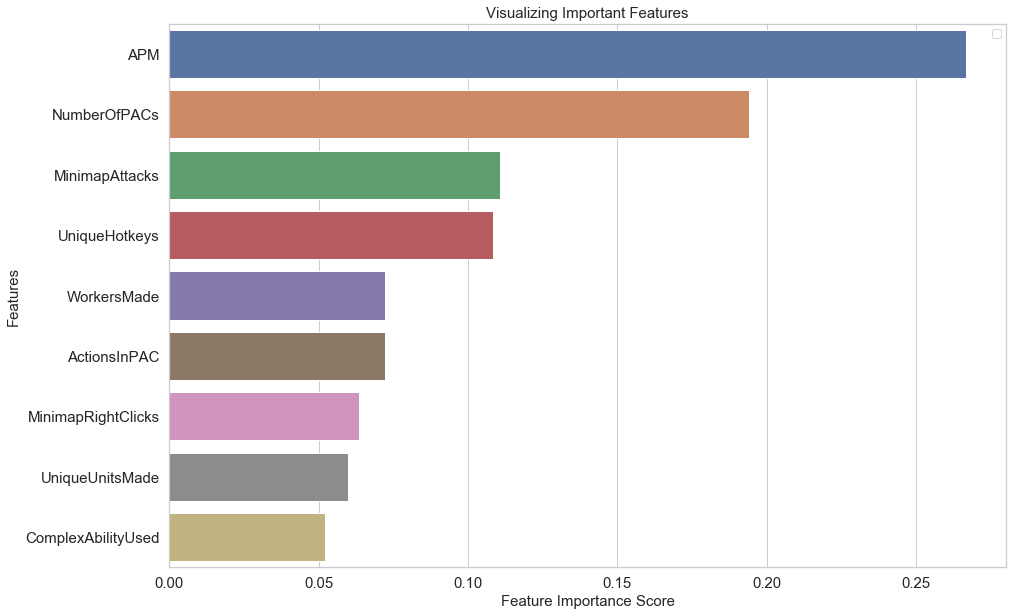

In [15]:
from matplotlib import figure
feature_imp = pd.Series(rfc.feature_importances_,index=X_train.columns, ).sort_values(ascending=False)
# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(15,10))
sns.set(style="whitegrid")
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Visualizing Important Features", fontsize=15)
plt.legend()
plt.show()

- The feature importances are good to see. Unsurprisingly __APM and PACs__ are the most informative features. 